# Part 3: Identifying Archetypes  
In the [Vermont Computational Story Lab's](https://compstorylab.org/archetypometrics/) analysis of the same dataset, they used "dimension reduction" to identify 6 key dimensions in the data that create 12 archetypes. However, because the replication code has not been made available, it is unclear what techniques they used to reduce the dimensionality of the data. In this section, we employ a mixture of principal component analysis (PCA), Gaussian mixture model (GMM), and hierarchical agglomerative clustering (HAC) to propose some potential archetypes.

### Importing modules and data

In [36]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram

We read and clean the data using the steps outlined in Part 1.

In [37]:
# read processed data from part 1 notebook
data = pd.read_csv("data/processed/char_score_data.csv")
data.head()

,id,character,source,playful_serious,shy_bold,cheery_sorrowful,masculine_feminine,charming_awkward,lewd_tasteful,intellectual_physical,...,cringing-away_welcoming-experience,stereotypical_boundary-breaking,energetic_mellow,hopeful_fearful,likes-change_resists-change,manic_mild,old-fashioned_progressive,gross_hygienic,stable_unstable,overthinker_underthinker
0,HML/1,Prince Hamlet,Hamlet,62.4,69.8,92.6,31.9,61.2,53.5,28.8,...,27.5,78.8,40.5,53.4,77.4,14.0,56.3,51.4,87.4,8.2
1,HML/2,Queen Gertrude,Hamlet,79.1,62.2,68.5,78.1,36.9,40.3,42.6,...,42.8,23.9,84.9,73.7,49.0,73.7,21.1,71.0,26.3,63.3
2,HML/3,King Claudius,Hamlet,83.2,85.3,69.4,21.8,39.1,35.8,49.9,...,11.3,29.7,50.7,78.6,68.2,20.3,31.6,48.7,74.3,55.0
3,HML/4,Polonius,Hamlet,72.5,65.0,67.1,28.2,66.3,47.9,30.4,...,31.6,22.2,75.7,60.4,79.0,55.9,25.5,48.2,80.1,49.6
4,HML/5,Ophelia,Hamlet,40.7,48.1,81.8,90.0,52.6,59.3,41.1,...,35.6,42.4,75.0,61.7,61.3,15.1,57.3,54.7,90.3,24.9


### Principal Component Analysis (PCA)

For PCA, it's important to scale variable values because we are comparing Euclidean distances. Technically, all of our variables should already be on the same scale, but this will become more important when we get to the self-organizing map, so we'll scale them here for consistency. _Robustness check: scaling the variables produces very similar results to the unscaled version. Just try running the PCA code without scaling the data!_

In [38]:
data_values = data.iloc[:, 3:]
scaler = StandardScaler()
data_values = scaler.fit_transform(data_values)

Now `data_values` contains our scaled data. It's time to see how many components we should have. This first technique is adapted from [this tutorial](https://mikulskibartosz.name/pca-how-to-choose-the-number-of-components). The author recommends that the number of components chosen should account for 95% of the variance. We'll see why this is an issue in a moment.

In [39]:
pca_all = PCA().fit(data_values) # fit the PCA to the maximum number of components

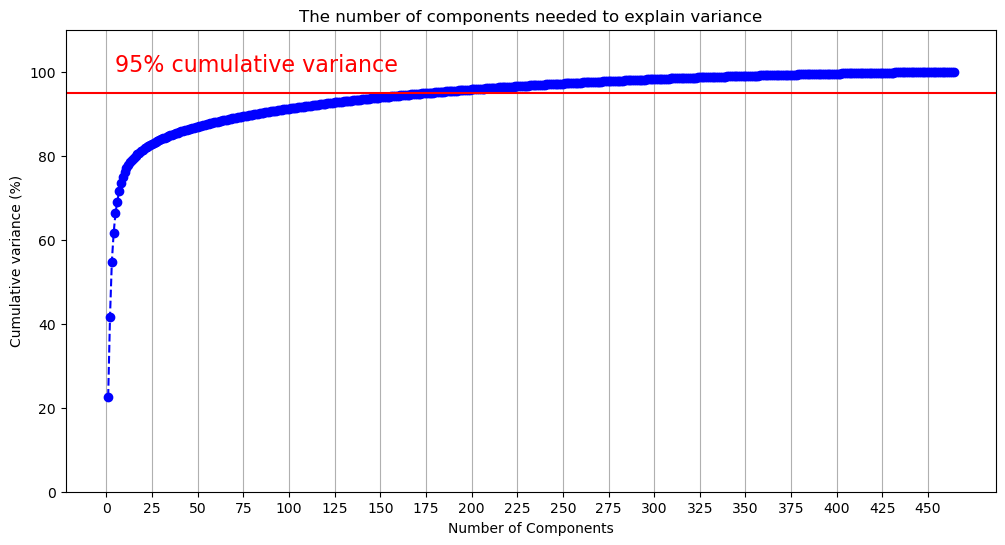

In [40]:
plt.rcParams["figure.figsize"] = (12,6)

xi = np.arange(1, 465, step=1)
y = np.cumsum(pca_all.explained_variance_ratio_) * 100

plt.ylim(0,110)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xticks(np.arange(0, 465, step=25))

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=95, color='r', linestyle='-')
plt.text(5, 100, '95% cumulative variance', color = 'red', fontsize=16)

plt.grid(axis='x')
plt.savefig("visualizations/cumulative_variance_PCA.png")
plt.show()

The above figure demonstrates that we will need many components to capture 95% of the variance. The code below outputs the first component where the cumulative variance exceeds 95%.

In [41]:
np.argmax(y > 95)

np.int64(177)

177 components doesn't reduce the dimensionality of the data very much! Let's flip the figure and see how much variance is captured by each component. Given our previous results, we'll limit this to the first 50 components to make the data more legible.

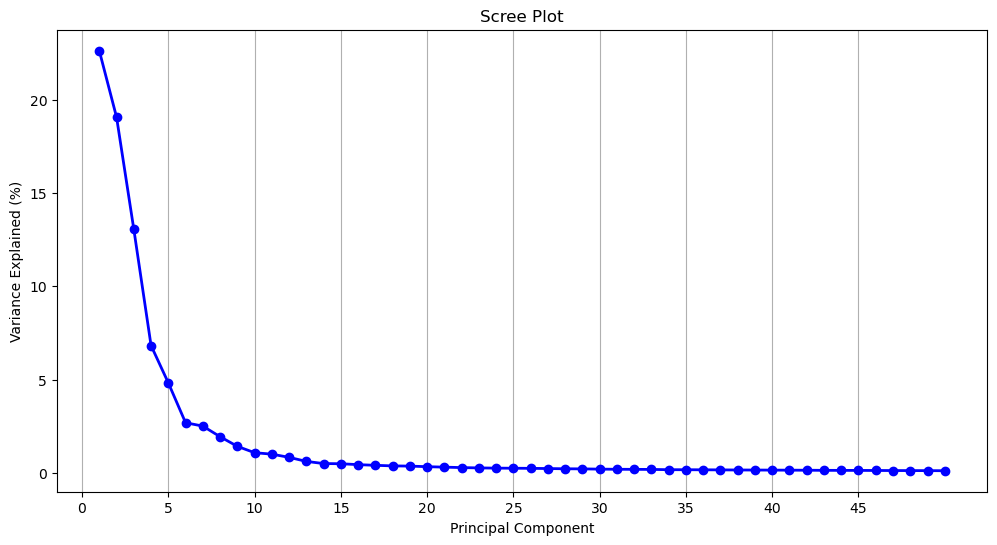

In [42]:
component_variance = np.arange(pca_all.n_components_) + 1

plt.plot(component_variance[:50], pca_all.explained_variance_ratio_[:50] * 100, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.xticks(np.arange(0, 50, step=5))
plt.grid(axis='x')
plt.savefig("visualizations/scree_plot_PCA.png")
plt.show()

Another common dimension reduction strategy is to only select components from before the curve begins to flatten out, which would be 5 components. At 5 components, 66.4% of the variance is captured.

In [43]:
y[4] / 100 # variance at the 5th component

np.float64(0.6638636017740732)

Which of the 500 dimensions contribute the most to each of the components? To know this, we can access the component loadings. Loadings tell us both the magnitude and direction of a given dimension, which, together indicate how the dimension contributes to the presence of a given component: A (relatively) larger, positive loading suggests that that dimension contributes more to the presence of that component. We can access these components from our fitted PCA using the `.components_` method.

In [44]:
pca_loadings = pca_all.components_.T # get the loadings

pca_loadings_df = pd.DataFrame( 
    pca_loadings,
    index=data.columns[3:].to_list(),
    columns=[f"PC{i+1}" for i in range(pca_loadings.shape[1])]
)

In [45]:
pca_loadings_df.abs().sort_values("PC1", ascending=False)[0:10]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC455,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464
rude_respectful,0.091049,0.000786,0.002063,0.003460,0.008549,0.001609,0.015161,0.036788,0.045929,0.042246,...,0.049400,0.060371,0.100228,0.029394,0.036369,0.153274,0.115065,0.042647,0.138371,0.034175
angelic_demonic,0.090436,0.024102,0.003288,0.001533,0.008813,0.022727,0.009448,0.016411,0.011535,0.001083,...,0.198838,0.156303,0.191531,0.247584,0.015800,0.024033,0.250777,0.396217,0.137798,0.061879
debased_pure,0.089346,0.015866,0.005647,0.007553,0.001962,0.042973,0.017397,0.000478,0.000606,0.049945,...,0.194477,0.016964,0.076680,0.001773,0.019710,0.027535,0.070315,0.001312,0.054646,0.060061
poisonous_nurturing,0.089226,0.021468,0.017706,0.017394,0.012439,0.022997,0.010411,0.016823,0.032178,0.014777,...,0.038700,0.160381,0.040732,0.005284,0.148581,0.032917,0.101725,0.428054,0.145874,0.141520
wholesome_salacious,0.088797,0.021813,0.005181,0.018322,0.002297,0.033965,0.018501,0.004646,0.008696,0.000223,...,0.078823,0.024919,0.122622,0.033720,0.143083,0.004715,0.058657,0.022001,0.008121,0.039529
naughty_nice,0.088582,0.012386,0.015223,0.003893,0.000311,0.028778,0.005096,0.001875,0.004208,0.011216,...,0.028465,0.003420,0.037170,0.006023,0.009307,0.004371,0.005895,0.039029,0.021252,0.019270
selfish_altruistic,0.087014,0.006984,0.023244,0.044968,0.000418,0.032253,0.009682,0.005270,0.004584,0.012065,...,0.215674,0.046954,0.068178,0.082714,0.104898,0.008414,0.331537,0.238263,0.219785,0.102549
empath_psychopath,0.086623,0.022962,0.016261,0.015969,0.017792,0.017963,0.033637,0.034696,0.032347,0.024039,...,0.074004,0.049257,0.044105,0.118591,0.131993,0.030945,0.069435,0.073952,0.053691,0.015162
arrogant_humble,0.086449,0.019651,0.001892,0.044850,0.014252,0.008091,0.015160,0.021335,0.004916,0.016996,...,0.121234,0.134285,0.136742,0.177373,0.190729,0.067924,0.081502,0.142948,0.097975,0.063000
cunning_honorable,0.086380,0.007392,0.000039,0.032619,0.031881,0.050038,0.002808,0.003871,0.010216,0.001639,...,0.077148,0.028651,0.100133,0.078692,0.203552,0.018443,0.117743,0.008812,0.019840,0.049601


Below, we retrieve the top 10 loadings from the first 5 components. We swap their values (e.g., 0.091049) for the dimension's name (e.g., `rude_respectful`). Then, we add the loading's sign (positive or negative) to the name. How do we interpret this? `PC1`'s top 2 loadings come from the dimensions `+rude_respectful` and `-angelic_demonic`. This tells us that both dimension contribute to the presence of `PC1` but that they are inversely related. This should hopefully make sense: Someone who scores highly on `respectful` would be expected to score lower on `demonic`. _When interpreting the dimensions, remember that the right-hand side corresponds to the higher scores, and the left-hand side corresponds to the lower scores_. Interpreting the loadings, the first five components seem to get at the following dichotomies:
* "good" vs "bad"
* "serious" vs "silly"
* "bland" vs "cool"
* "refined" vs "rough"
* "smart" vs "strong"

In [46]:
loadings = {}

for i in range(1, 6):
    comp = f"PC{i}"
    
    # get top dimensions by absolute loading
    top_idx = (pca_loadings_df[comp].abs().sort_values(ascending=False).head(11).index
    )
    
    # add sign (i.e., direction) to dimension names
    signed_dims = [
        f"{'+' if pca_loadings_df.loc[idx, comp] >= 0 else '-'}{idx}"
        for idx in top_idx
    ]
    
    loadings[comp] = signed_dims

comp_loadings_dimensions = pd.DataFrame(loadings)
comp_loadings_dimensions

,PC1,PC2,PC3,PC4,PC5
0,+rude_respectful,+random_pointed,+charismatic_uninspiring,+scruffy_manicured,+lumberjack_mad-scientist
1,-angelic_demonic,+playful_serious,-mundane_extraordinary,-glamorous_spartan,-nerd_jock
2,+debased_pure,-strict_lenient,-tiresome_interesting,-refined_rugged,+sporty_bookish
3,+poisonous_nurturing,+goofy_unfrivolous,+badass_weakass,+proletariat_bourgeoisie,-intellectual_physical
4,-wholesome_salacious,-rational_whimsical,+adventurous_stick-in-the-mud,+blue-collar_ivory-tower,+common-sense_analysis
5,+naughty_nice,-focused_absentminded,-repetitive_varied,+punk-rock_preppy,-cat-person_dog-person
6,+selfish_altruistic,-studious_goof-off,+open-to-new-experinces_uncreative,-tailor_blacksmith,+macho_metrosexual
7,-empath_psychopath,+spontaneous_deliberate,+brave_careful,-extravagant_thrifty,+straightforward_cryptic
8,+arrogant_humble,-coordinated_clumsy,+maverick_conformist,+frugal_lavish,-philosophical_real
9,+cunning_honorable,+disorganized_self-disciplined,+vibrant_geriatric,-cosmopolitan_provincial,+normal_weird


For a quick sanity check, we can see how Bruce Wayne (aka Batman) stacks up against the average fictional character on each of these measures. Batman is close to the mean on the first, fourth, and fifth components, but he is one 1.26 standard deviations above the mean "seriousness" and nearly 1 standard deviation below the mean "blandness."

_You can use the lookup below to find a character of your choosing (if they're in the dataset). Then input their index into the second cell below, which finds their scores in order of the five components above._

In [47]:
char_key.index[char_key["name"] == "Bruce Wayne"].to_list()
# this will give 2 numbers for characters who appear in multiple series, 
# like Bruce Wayne in Gotham and The Dark Knight

[874, 941]

In [48]:
scores = pca_all.transform(data_values)
character_scores = scores[941][0:5]
mean_scores = scores.mean(axis=0)[0:5]
std_scores = scores.std(axis=0)[0:5]
z_scores = (character_scores - mean_scores) / std_scores
z_scores

array([-0.37252782,  1.25955851, -0.96757578,  0.43020426,  0.50828762])

### Clustering
#### Gaussian Mixture Models
While PCA reduces dimensions, it does not cluster our data. However, we can use PCA to cluster the data with reduced noise from excess dimensions. One way of clustering our data is through a Gaussian Mixture Model. This model is ideal for its probabilistic nature: It would allow us to have "soft" clusters, with some characters occupying the boudnaries between multiple archetypes. To quickly test this model out, we can input the 177 components of our PCA (which explain 95% of the variance) and cluster our characters into one of two groups. We can plot each character on a scatterplot with the first two principle components as the axes.

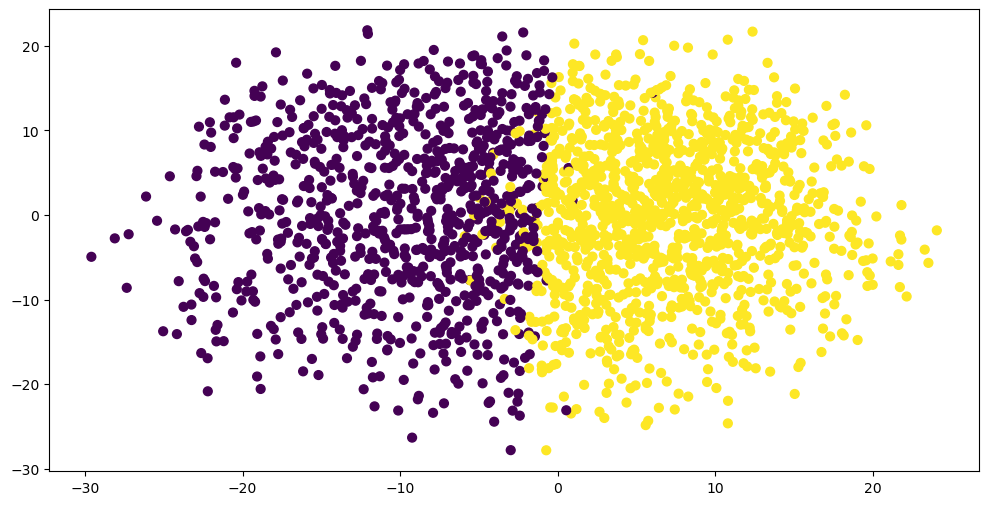

In [49]:
pca_scores = scores[:, :177] # select first 177 components, change this to test other components

gmm = GMM(n_components=2, random_state=159, covariance_type="full").fit(pca_scores)
labels = gmm.predict(pca_scores)
plt.savefig("visualizations/GMM_2_components.png")
plt.scatter(scores[:, 0], scores[:, 1], c=labels, s=40, cmap='viridis')

So far, that looks pretty good! What characters fall into each group? This might help us assess the viability of this method. We can assign cluster labels to the chracters using `gmm.predict()` and inputting each character's score on the 177 components.

In [50]:
labels = gmm.predict(pca_scores) # retrieve cluster labels based on scores
data_clusters = data # create copy of the original dataset
data_clusters["GMM_cluster_2"] = labels # assign a new column with clusters
print(data_clusters[["character", "GMM_cluster_2"]][941:947])

             character  GMM_cluster_2
941        Bruce Wayne              0
942  Alfred Pennyworth              1
943          The Joker              0
944       James Gordon              1
945        Harvey Dent              0
946       Rachel Dawes              1


Looks like all the good guys and all the bad guys are clustered together...except Bruce Wayne. What's driving these cluster assignments? To try and interpret this division, we can take the mean of every PCA component for each of the clusters (`gmm.means_`) and then reverse the dimensionality reduction with `.inverse_transform`. We reinstantiate our PCA with only the first 177 components to do this.

In [51]:
pca177 = PCA(n_components=177).fit(data_values) # fit the PCA to the number of components provided to the GMM
cluster_centers_original = pca177.inverse_transform(gmm.means_) # find the means in the original dimensional space

Now, we go through each cluster and retrieve the original dimensions with the highest absolute average. We still care about the direction of the sign though, so we print the mean value alongside the dimension name. It turns out that the two clusters are just the opposite of one another: Cluster 0 is defined by being more `wholesome` while Cluster 1 is more `salacious`.

In [52]:
for i, center in enumerate(cluster_centers_original):
    top = np.argsort(np.abs(center))[-5:]
    print(f"Cluster {i}:")
    for idx in top:
        print(data.columns[3:].to_list()[idx], center[idx])

Cluster 0:
rude_respectful -0.9009697884920573
wholesome_salacious 0.9023321011746448
poisonous_nurturing -0.9066628193083551
naughty_nice -0.9089049600709965
angelic_demonic 0.9247723568817838
Cluster 1:
rude_respectful 0.6622479468301117
wholesome_salacious -0.6632492998038819
poisonous_nurturing 0.6664325465997045
naughty_nice 0.6680806075397367
angelic_demonic -0.6797437632789208


What if we do the same thing with more initial clusters?

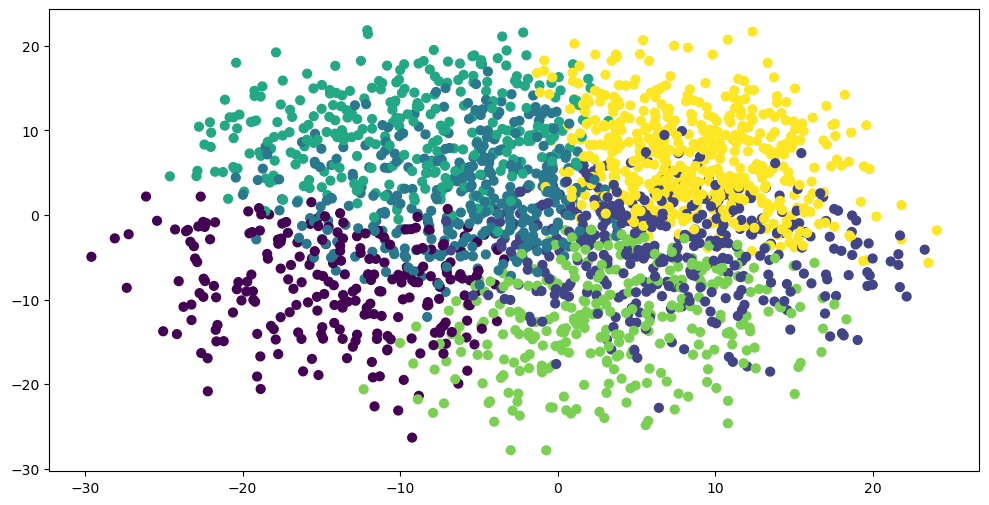

In [53]:
gmm = GMM(n_components=6, random_state=159, covariance_type="full").fit(pca_scores) # 
labels = gmm.predict(pca_scores)
plt.savefig("visualizations/GMM_6_components.png")
plt.scatter(scores[:, 0], scores[:, 1], c=labels, s=40, cmap='viridis')

In [54]:
labels = gmm.predict(pca_scores) # retrieve cluster labels based on scores
data_clusters = data # create copy of the original dataset
data_clusters["GMM_cluster_6"] = labels # assign a new column with clusters
print(data_clusters[["character", "GMM_cluster_6"]][941:947])

             character  GMM_cluster_6
941        Bruce Wayne              2
942  Alfred Pennyworth              5
943          The Joker              2
944       James Gordon              5
945        Harvey Dent              3
946       Rachel Dawes              5


In [55]:
pca177 = PCA(n_components=177).fit(data_values) # fit the PCA to the number of components provided to the GMM
cluster_centers_original = pca177.inverse_transform(gmm.means_) # find the means in the original dimensional space

for i, center in enumerate(cluster_centers_original):
    top = np.argsort(np.abs(center))[-5:]
    print(f"Cluster {i}:")
    for idx in top:
        print(data.columns[3:].to_list()[idx], center[idx])

Cluster 0:
ludicrous_sensible -1.4249028420782075
works-hard_plays-hard 1.4443748726555354
competent_incompetent 1.4568408791959941
lewd_tasteful -1.486334728385047
diligent_lazy 1.5269709267459943
Cluster 1:
timid_cocky -1.223718831093543
hesitant_decisive -1.2257103125857105
dominant_submissive 1.238521734878264
assertive_passive 1.2776410015576447
shy_bold -1.3759068803091339
Cluster 2:
maverick_conformist -0.9845973127773013
wild_tame -0.9984579206311573
spicy_mild -1.0095040937863942
obedient_rebellious 1.0194792799184147
tattle-tale_fuck-the-police 1.0789943900257073
Cluster 3:
open-minded_close-minded 1.3692957850016358
democratic_authoritarian 1.3900497609120483
protagonist_antagonist 1.39647728909825
cruel_kind -1.4123734447521963
soulless_soulful -1.4723816024929026
Cluster 4:
resentful_euphoric 1.2759967560600671
bubbly_flat -1.2900142154855703
cheery_sorrowful -1.290290487457384
playful_serious -1.3135276893630863
open_guarded -1.3564880039643183
Cluster 5:
ludicrous_sensib

With three times as many clusters, Bruce Wayne's allies all remain in the same group (one now defined by being _stable, sensible, factual, reasonable, and mature_). Meanwhile, Harvey Dents splits off, and The Joker and Bruce Wayne stay together. This suggests that, perhaps, a better technique for clustering the data would be _hierarchical_.

#### Hierarchical Clustering
While hierarchical clustering will employ different methods for differentiating clusters (and thus, is unlikely to replicate the clusters found through GMM), this is actually the reason for attempting to cluster the data with it: Perhaps what we need is a hierarchical approach to show how certain categories break down. We'll start by plotting a dendrogram to give us a sense of the shape of the data. 

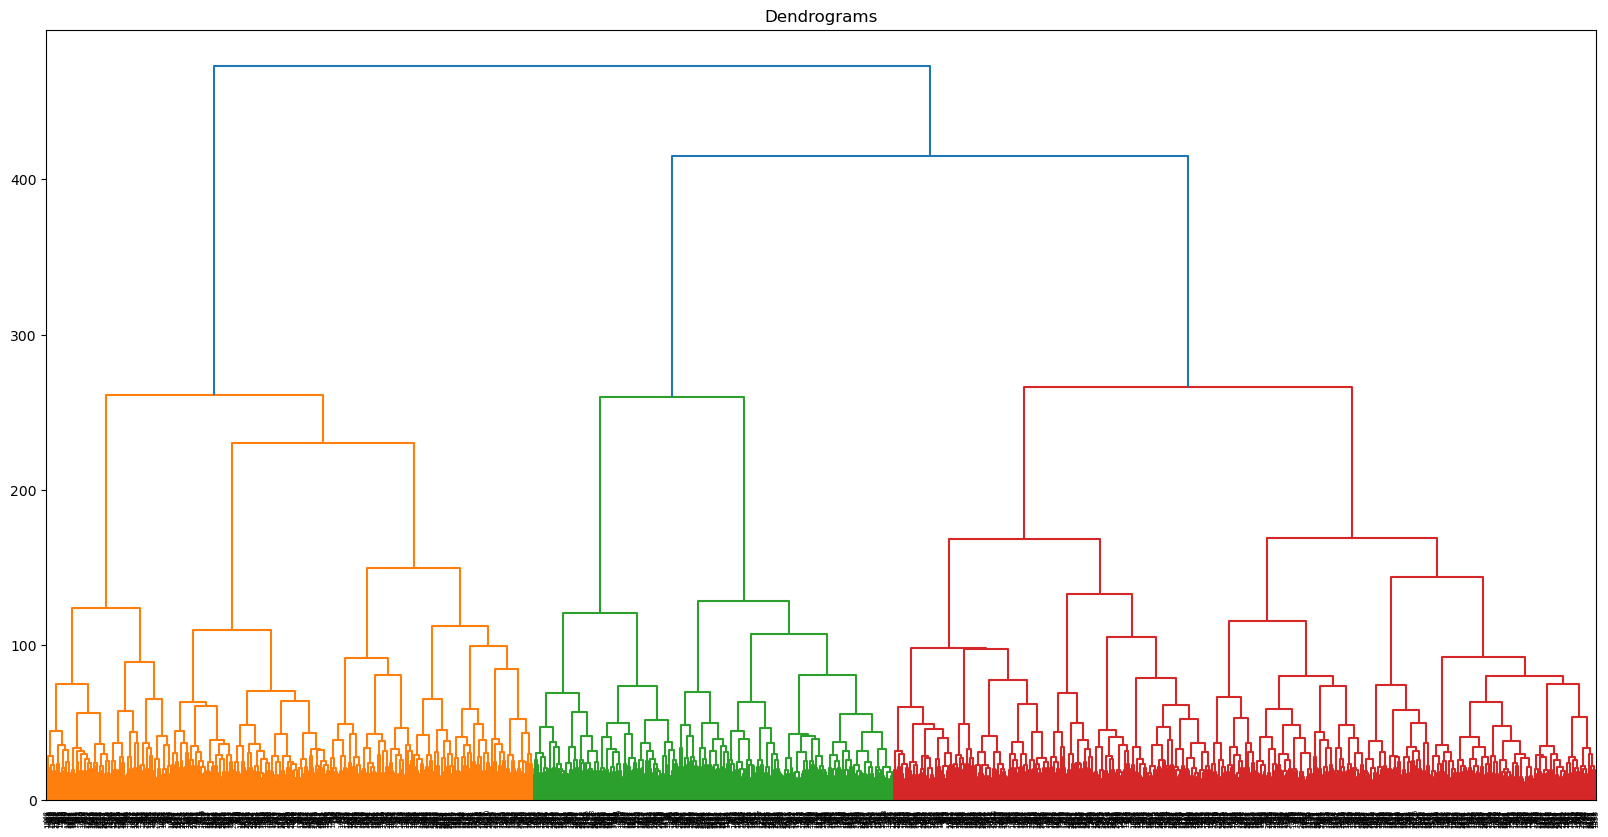

In [56]:
plt.figure(figsize = (20,10))
plt.title('Dendrograms')
# plot and save dendrogram
dend = dendrogram(linkage(scores[:, 0:177], method="ward", metric="euclidean"))
plt.savefig("visualizations/HCA_complete_dendrogram.png")

Let's start, as we did with GMM, by dividing the data into two clusters. We are still using the 177 components identified earlier. 

In [57]:
h_cluster = AgglomerativeClustering(
    n_clusters=2,
    metric='euclidean',
    linkage='ward',
    compute_full_tree=True).fit(pca_scores)

We can add the cluster labels to the previous cluster dataframe we had made during GMM. Now, we can compare the clusters assigned to each character.

In [58]:
data_clusters['HAC_cluster_2']=h_cluster.labels_ 
print(data_clusters[["character", "GMM_cluster_2", "HAC_cluster_2"]][941:947])

             character  GMM_cluster_2  HAC_cluster_2
941        Bruce Wayne              0              0
942  Alfred Pennyworth              1              0
943          The Joker              0              1
944       James Gordon              1              0
945        Harvey Dent              0              0
946       Rachel Dawes              1              0


Seems like The Joker is all alone in his own cluster. What differentiates these two groups? We can create a new dataframe with the clusters as columns and the original dimensions as rows—just like we did with our PCA. Repurposing that code, we can figure out which dimensions differentiate the clusters based on their average scores.

In [66]:
# create the cluster dataframe
data_values_hclust = pd.DataFrame(data_values, columns=data.columns[3:467].to_list())
data_values_hclust["hclust1"] = h_cluster.labels_

# find the mean for each cluster
cluster_means = data_values_hclust.groupby('hclust1').mean()

# track the dimensions with the highest means within the cluster
clust_deter = {}

for i in range(0, 2):
    
    # get top dimensions by absolute mean
    top_idx = (cluster_means.T[i].abs().sort_values(ascending=False).head(11).index)
    
    # add sign (i.e., direction) to dimension names
    signed_dims = [
        f"{'+' if cluster_means.T.loc[idx, i] >= 0 else '-'}{idx}"
        for idx in top_idx
    ]
    
    clust_deter[i] = signed_dims

cluster_dimensions = pd.DataFrame(clust_deter)
cluster_dimensions

,0,1
0,+quarrelsome_warm,-shy_bold
1,-angelic_demonic,-hesitant_decisive
2,+poisonous_nurturing,+confident_insecure
3,-wholesome_salacious,-self-conscious_self-assured
4,-empath_psychopath,-claustrophobic_spelunker
5,+fearmongering_reassuring,+assertive_passive
6,+stingy_generous,+badass_weakass
7,+arrogant_humble,+alpha_beta
8,+entitled_grateful,+spicy_mild
9,+selfish_altruistic,+dominant_submissive


Seems like the highest scoring dimensions speak for themselves: it's a difference between order and chaos, caution and impulse, the tame and the wild. The Joker certainly seems to make sense on the side of chaos.

Now we can enter into the hierarchy again, this time once 7 groups have been created, and run the same analysis.

In [60]:
h_cluster = AgglomerativeClustering(
    n_clusters=7, # change the number of clusters
    metric='euclidean',
    linkage='ward',
    compute_full_tree=True).fit(pca_scores)

In [61]:
data_clusters["HAC_cluster_7"]=h_cluster.labels_ 
print(data_clusters[["character", "HAC_cluster_2", "HAC_cluster_7"]][941:947])

             character  HAC_cluster_2  HAC_cluster_7
941        Bruce Wayne              0              2
942  Alfred Pennyworth              0              0
943          The Joker              1              6
944       James Gordon              0              2
945        Harvey Dent              0              2
946       Rachel Dawes              0              0


In [67]:
# create the cluster dataframe
data_values_hclust = pd.DataFrame(data_values, columns=data.columns[3:467].to_list())
data_values_hclust["hclust1"] = h_cluster.labels_

# find the mean for each cluster
cluster_means = data_values_hclust.groupby('hclust1').mean()

# track the dimensions with the highest means within the cluster
clust_deter = {}

for i in range(0, 7):
    
    # get top dimensions by absolute mean
    top_idx = (cluster_means.T[i].abs().sort_values(ascending=False).head(11).index)
    
    # add sign (i.e., direction) to dimension names
    signed_dims = [
        f"{'+' if cluster_means.T.loc[idx, i] >= 0 else '-'}{idx}"
        for idx in top_idx
    ]
    
    clust_deter[i] = signed_dims

cluster_dimensions = pd.DataFrame(clust_deter)
cluster_dimensions

,0,1,2,3,4,5,6
0,+quarrelsome_warm,-shy_bold,-rational_whimsical,-lewd_tasteful,-open_guarded,-soulless_soulful,-adventurous_stick-in-the-mud
1,-angelic_demonic,-hesitant_decisive,+dramatic_no-nonsense,+clean_perverted,-playful_serious,-cruel_kind,+obedient_rebellious
2,+poisonous_nurturing,+confident_insecure,+juvenile_mature,-inappropriate_seemly,-random_pointed,+heroic_villainous,+tattle-tale_fuck-the-police
3,-wholesome_salacious,-self-conscious_self-assured,-concise_long-winded,+good-manners_bad-manners,-spontaneous_deliberate,+protagonist_antagonist,-wild_tame
4,-empath_psychopath,-claustrophobic_spelunker,-down2earth_headinclouds,-ludicrous_sensible,-loose_tight,-clinical_heartfelt,-maverick_conformist
5,+fearmongering_reassuring,+assertive_passive,-sturdy_flimsy,+prestigious_disreputable,+focused_absentminded,-genocidal_not-genocidal,-anarchist_statist
6,+stingy_generous,+badass_weakass,-objective_subjective,-rude_respectful,+rational_whimsical,+democratic_authoritarian,+stereotypical_boundary-breaking
7,+arrogant_humble,+alpha_beta,-factual_exaggerating,+works-hard_plays-hard,+studious_goof-off,+warm_cold,-radical_centrist
8,+entitled_grateful,+spicy_mild,-grounded_fantasy-prone,+diligent_lazy,-imaginative_practical,+friendly_unfriendly,+repetitive_varied
9,+selfish_altruistic,+dominant_submissive,-parental_childlike,+devout_heathen,-gregarious_private,+empath_psychopath,-spicy_mild


The Joker stays on his lonesome, but his new cluster is defined by "adventurous", "rebellious", and "fuck the police"—so it seems like an appropriate place for him. Meanwhile, the agents of order have been split into two camps: butler Alfred Pennyworth and district attorney / love interest Rachel Dawes are "warm", "angelic", and "nurturing", while vigilante Bruce Wayne, lawyer-turned-killer Harvey Dent, and police commissioner James Gordon are all "rational", "no nonsense", and "mature."

For a final attempt at interpreting the data, we can label each "leaf" of the tree with the most prominent dimension and cut the tree off to visualize the hierarchy. This code is (very minorly) adapted from [stack overflow](https://stackoverflow.com/questions/35873273/display-cluster-labels-for-a-scipy-dendrogram).

values passed to leaf_label_func
leaves :  [4245, 4247]


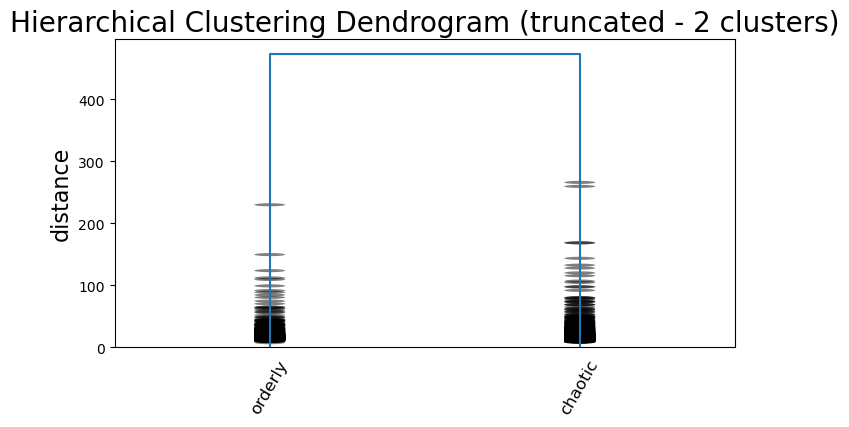

<Figure size 1200x600 with 0 Axes>

In [63]:
labels = ["orderly", "chaotic"]
linked = linkage(scores[:, 0:177], method="ward", metric="euclidean")
p = len(labels)

plt.figure(figsize=(8,4))
plt.title('Hierarchical Clustering Dendrogram (truncated - 2 clusters)', fontsize=20)
plt.ylabel('distance', fontsize=16)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])

# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

dendrogram(
            linked,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
plt.show()
plt.savefig("visualizations/HCA_2cluster_dendrogram.png")

values passed to leaf_label_func
leaves :  [4236, 4232, 4240, 4235, 4237, 4241, 4242]


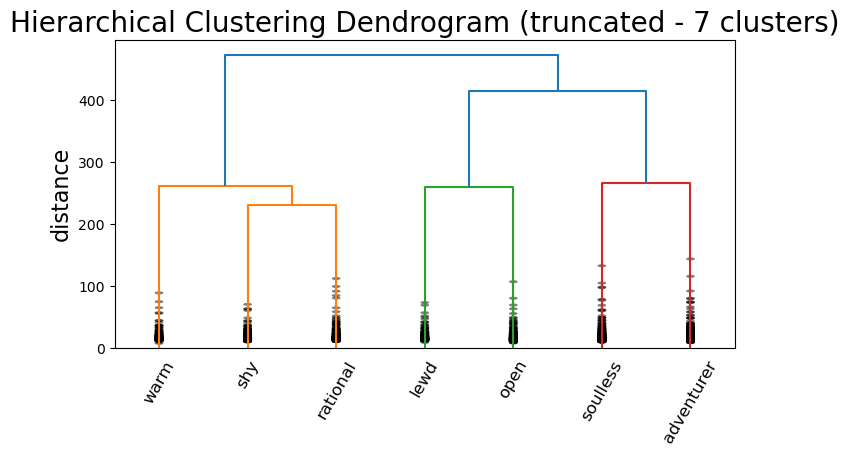

<Figure size 1200x600 with 0 Axes>

In [64]:
labels = ["warm", "shy", "rational", "lewd", "open", "soulless", "adventurer"]
linked = linkage(scores[:, 0:177], method="ward", metric="euclidean")
p = len(labels)

plt.figure(figsize=(8,4))
plt.title('Hierarchical Clustering Dendrogram (truncated - 7 clusters)', fontsize=20)
plt.ylabel('distance', fontsize=16)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])

# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

dendrogram(
            linked,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
plt.show()
plt.savefig("visualizations/HCA_7cluster_dendrogram.png")

Where does this leave us? Certainly, we did not produce the same archetypes as the Vermont Computational Story Lab (CSL). Their 6 major dimensions are roughly approximated by our 5 components derived via PCA, but they were not exact. These axes seemed more true to what we might consider "archetypes": PC5, for example, described tropes of characters defined by their brains or their brawn, which corresponds to CSL's "brute vs geek" dimension. When it came to GMM, the major distinctions didn't capture the heros vs the villains, but seemed to capture a general personality difference. The more psychological aspects of the character archetypes became clear with the hierarchical clustering. This makes sense given the fact that Open Psychometrics relies on personality-based metrics—it's even in the name.

With some interpretive leverage, we could identity the major differentiation between characters as whether or not they are agents of order or chaos—an important distinction in how characters move plots along. On the side of order, there are characters defined by their warmth and kindness, their shyness and meekness, or their wise rationality. On the side of chaos, there are characters defined by their perversion, their gregariousness and charm, their cruelty and villainy, and their wild rebelliousness.